In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim

import pytorch_lightning as pl
from pytorch_lightning.accelerators import accelerator
from torchmetrics import functional as FM
from torchinfo import summary

from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 3.5]
plt.rcParams["font.size"] = "8"

from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

def dataLoader(batch_size=128):
    train_dataset = MNIST('', transform=transforms.ToTensor(), train=True, download=True) ## 한 번 인터넷으로 가져온걸 매번 가져올 필요가 없기 때문에 가져올때 download True 로 하면 다음 부터는 다운로드 된 데이터를 사용한다.
    test_dataset = MNIST('', transform=transforms.ToTensor(), train=False, download=True)
    trainDataLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valDataLoader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return (trainDataLoader,valDataLoader)

trainDataLoader,valDataLoader = dataLoader()

In [2]:
loss_function = nn.CrossEntropyLoss() ## 회귀가 아닌 분류의 문제이므로 cross entropy 를 loss 로 사용한다. 

class mymodel( pl.LightningModule ):  
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(  
            nn.Flatten(),
            nn.Linear( 28*28, 10 ),
        )

    def forward(self, x):
        out = self.layers(x)
        return out
         
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = loss_function(y_pred, y)
        return loss
        
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)


# 모델 리뷰 

바로 전번에 돌린 모델을 보면, 이상한 점이 두 개 있다. 전에 사용했던 keras의 경우 categorical data의 cross entropy 를 계산하기 위해서는 output 되는 값을 확률 분포로 바꿔주고 (logit -> softmax 를 통한 prob), 또한 target y 값도 one-hot encoding 을 통해서 같은 dimmension 으로 바꿔줘야 확률분포의 차이 즉 크로스 엔트로피가 계산이 되었다. 근데 여기서는 그냥 y_pred (선형결합으로 이루어진 ~ logit 값, dim=10)  과  y (target 값, dim=1) 를 그냥 넣어주었다. 

이게 가능한 이유는 파이토치에서 이 부분을 자동으로 해주기 때문이다. 다음을 보자

In [3]:
tensor1 = torch.tensor( [[0, 0.5, 0.5, 0]] )
tensor2 = torch.tensor( [[0, 1, 0., 0]] )

out = loss_function(tensor1, tensor2)
out.item()

1.1672241687774658

이걸 softmax를 취하지 않은 형태의 tensor에 대해서 적용해도 별 문제 없다.

물론 정확히 Softmax를 취한 값과는 값이 살짝 다른데 이유는 cross entropy 에서 실행되는 softmax 는 log_softmax 이기 때문이다. (하지만 어차피 loss 는 경향을 보는 거지 절대값 자체가 중요한건 아니기 때문에..)

In [4]:
tensor1 = torch.tensor( [[0, 111.5, 111.5, 0]] )
tensor2 = torch.tensor( [[0, 1, 0., 0]] )

out = loss_function(tensor1, tensor2)
out.item()

0.6931471824645996

In [5]:
tensor1 = torch.tensor( [[0, 111.5, 111.5, 0]] )
tensor2 = torch.tensor( [[0, 1, 0., 0]] )

softmax_layer = nn.LogSoftmax(dim=1)
tensor_softmaxed = softmax_layer(tensor1)  ## [[0, 0.5, 0.5, 0]] 으로 변환됨 
out = loss_function(tensor_softmaxed, tensor2)
out.item()

0.6931471824645996

그런데 더 놀라운 사실은 이 뿐만 아니라 one-hot encoding도 알아서 해준다. (true_y 가 pred_y 와 같은 shape 이면 그대로 확률을 비교하고, 그렇지 않다면 one-hot encoding을 진행한다)

In [6]:
tensor1 = torch.tensor( [[0, 111.5, 111.5, 0]] )
tensor2 = torch.tensor( [1] )  ## 확률 벡터가 아니라, 그냥 index만 넣어줘도! 

out = loss_function(tensor1, tensor2)
out.item()

0.6931471824645996

참 편리하다. 

## 모델 개선

모델을 돌려서 학습까지 했지만, 뭐 나온게 없으므로 현 수준은 그냥 에러가 나지 않고 뭔가가 돌아갔다는 데 위안을 둬야한다. 이제 실제 성능을 확인하기 위해 몇가지를 개선하자

In [7]:
loss_function = nn.CrossEntropyLoss() ## 회귀가 아닌 분류의 문제이므로 cross entropy 를 loss 로 사용한다. 

class mymodel2( pl.LightningModule ):  
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(  
            nn.Flatten(),
            nn.Linear( 28*28, 10 ),
        )

    def forward(self, x):
        out = self.layers(x)
        return out
         
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10) ## accuracy 를 계산해서
        self.log_dict({'loss':loss, 'acc':acc})  # loss 와 함께 log 에 저장한다. 
        return loss 
         
    def validation_step(self, batch, batch_idx):   ## training 과 같은 꼴이지만 역전파를 하지 않기 때문에 loss를 리턴하지 않는다.
        x, y = batch
        y_pred = self(x)
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        self.log_dict({'val_loss':loss, 'val_acc':acc}) # 한 epoch 이 끝나면 validation 이 돌고, 이 때 역시 log에 결과를 저장한다.
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [8]:
mm = mymodel2()

In [9]:
%%time
epochs = 3
logger = pl.loggers.CSVLogger("logs", name="firstModel")  ## 결과를 확인하기 위해 log 를 저장했다. 
trainer = pl.Trainer(max_epochs=epochs, logger=logger, accelerator="auto") # auto 로 설장하면 gpu 가 있으면 gpu를 사용해서 실행된다.
trainer.fit(mm, trainDataLoader, valDataLoader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 7.9 K 
--------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.031     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/anaconda3/envs/python3_11_8/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/anaconda3/envs/python3_11_8/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


CPU times: user 8.87 s, sys: 5.26 s, total: 14.1 s
Wall time: 14.2 s


In [10]:
v_num = logger.version  ## 버전에 따라서 폴더가 구분되므로, 최근에 돌린 버전을 확인 
history = pd.read_csv(f'./logs/firstModel/version_{v_num}/metrics.csv') ## 파일 읽어오기 
history ## 결과 

,acc,epoch,loss,step,val_acc,val_loss
0,0.882812,0,1.0,49,NaN,NaN
1,0.843750,0,1.0,99,NaN,NaN
2,0.882812,0,1.0,149,NaN,NaN
3,0.843750,0,1.0,199,NaN,NaN
4,0.890625,0,1.0,249,NaN,NaN
5,0.882812,0,1.0,299,NaN,NaN
6,0.914062,0,1.0,349,NaN,NaN
7,0.906250,0,1.0,399,NaN,NaN
8,0.875000,0,1.0,449,NaN,NaN
9,NaN,0,NaN,468,0.9021,0.379996


epoch에서 batch 단위로 로그가 저장됨을 알 수 있다. 기본적으로 training 이 한바퀴 돌고 validation 이 실행된다.
epoch 단위로만 보고 싶다면

In [11]:
history.groupby('epoch').last().drop('step', axis=1)

,acc,loss,val_acc,val_loss
epoch,,,,
0,0.875000,1.0,0.9021,0.379996
1,0.914062,1.0,0.9140,0.317711
2,0.921875,1.0,0.9181,0.295831


MNIST 의 경우 너무 분류가 너무 쉬운 코드이기 때문에 별다른 trick 없이 10개의 dense layer 만으로도 90% 의 정분류율을 보여준다.

실제 어떻게 예측했는지를 좀 더 detail 하게 확인하기 위해서 validation 데이터를 하나 꺼내본다.

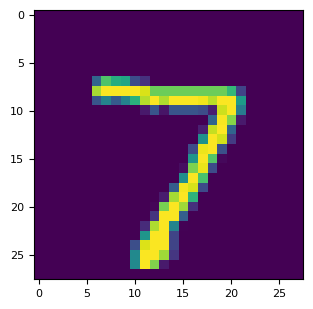

In [12]:
test_batch = next(iter(valDataLoader)) # 1개 배치씩 가져옴

#test_img[0] #그중에 첫번째
test_img = test_batch[0][0] # 그중에 이미지
plt.imshow(test_img.reshape(28, 28))

In [13]:
mm.forward(test_img)  ## tensor 로 나오기 때문에 앞([0]) 부분은 logit 값이고, 뒤는 tensor grad 정보

tensor([[-1.6850, -8.3828, -1.3778,  2.2044, -3.7540, -1.9340, -7.0674,  7.7723,
         -1.4259,  1.3060]], grad_fn=<AddmmBackward0>)

In [14]:
torch.softmax(mm.forward(test_img)[0], dim=0)

tensor([7.7679e-05, 9.5819e-08, 1.0561e-04, 3.7971e-03, 9.8115e-06, 6.0554e-05,
        3.5706e-07, 9.9430e-01, 1.0065e-04, 1.5462e-03],
       grad_fn=<SoftmaxBackward0>)

In [15]:
prob = torch.softmax(mm.forward(test_img)[0], dim=0).detach() ## grad 등 불필요한 정보는 빼버리고 
np.argmax(prob)

tensor(7)

실제로 class index 와 같이 나옴을 확인할 수 있다.